In [ ]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

2.2.0


In [ ]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [ ]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://download.tensorflow.org/data/spa-eng.zip', 
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [ ]:
!mv {path_to_file} ./

In [ ]:
lines= pd.read_table('spa.txt', names=['eng', 'spa'])

In [ ]:
len(lines)

118964

In [ ]:
lines = lines[:30000]

In [ ]:
lines.head()

,eng,spa
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [ ]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.spa=lines.spa.apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.spa=lines.spa.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.spa=lines.spa.apply(lambda x: re.sub(" +", " ", x))

In [ ]:
# Add start and end tokens to target sequences 
lines.spa = lines.spa.apply(lambda x : 'START_ '+ x + ' _END')

In [ ]:
lines.head()

,eng,spa
0,Go.,START_ Ve. _END
1,Go.,START_ Vete. _END
2,Go.,START_ Vaya. _END
3,Go.,START_ Váyase. _END
4,Hi.,START_ Hola. _END


In [ ]:
# Vocabulary of English
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

# Vocabulary of Spanish
all_spa_words=set()
for spa in lines.spa:
    for word in spa.split():
        if word not in all_spa_words:
            all_spa_words.add(word)

In [ ]:
# Max Length of source sequence
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

7

In [ ]:
# Max Length of target sequence
lenght_list=[]
for l in lines.spa:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar


14

In [ ]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_spa_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_spa_words) + 1 # plus 1 is for padding
num_encoder_tokens, num_decoder_tokens

(8142, 15077)

In [ ]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [ ]:
# Train - Test Split
X, y = lines.eng, lines.spa
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1)
X_val, X_test, y_val ,y_test = train_test_split(X_val, y_val, test_size = 0.5)
X_train.shape, X_val.shape , X_test.shape ,y_train.shape , y_val.shape ,y_test.shape

((27000,), (1500,), (1500,), (27000,), (1500,), (1500,))

In [ ]:
X_train[1:2]

17989    Tom almost drowned.
Name: eng, dtype: object

In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 512):
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word]
                for t, word in enumerate(target_text.split()):
                    decoder_input_data[i, t] = target_token_index[word]
                    if t>0:
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield ([encoder_input_data, decoder_input_data], decoder_target_data)

In [ ]:
latent_dim = 128
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens+1, latent_dim, mask_zero = False,name="state",input_length=1)(encoder_inputs)
encoder_lstm = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]


In [ ]:
# decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens+1, latent_dim, mask_zero = False,name="dstate",input_length=1)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
state (Embedding)               (None, None, 128)    1042304     input_1[0][0]                    
__________________________________________________________________________________________________
dstate (Embedding)              (None, None, 128)    1929984     input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_val, y_val, batch_size = batch_size),
                    validation_steps = int(val_samples//batch_size)
                   )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
210/210 [==============================] - 33s 157ms/step - loss: 2.1513 - acc: 0.0736 - val_loss: 1.9024 - val_acc: 0.0790
Epoch 2/50
210/210 [==============================] - 32s 152ms/step - loss: 1.7843 - acc: 0.0830 - val_loss: 1.7672 - val_acc: 0.0864
Epoch 3/50
210/210 [==============================] - 32s 154ms/step - loss: 1.6426 - acc: 0.0913 - val_loss: 1.6668 - val_acc: 0.0994
Epoch 4/50
210/210 [==============================] - 32s 154ms/step - loss: 1.5364 - acc: 0.1025 - val_loss: 1.6064 - val_acc: 0.1053
Epoch 5/50
210/210 [==============================] - 32s 154ms/step - loss: 1.4514 - acc: 0.1100 - val_loss: 1.5517 - val_acc: 0.1100
Epoch 6/50
210/210 [==============================] - 32s 155ms/step - loss: 1.3693 - acc: 0.1188 - val_loss: 1.4979 - val_acc: 0.1173
Epoch 7/50
210/210 [==============================] - 32s 154ms/step - loss: 1.2890 - acc: 0.1279 - val_loss: 1.44

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


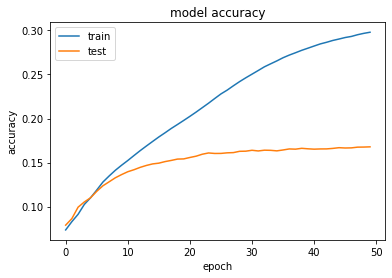

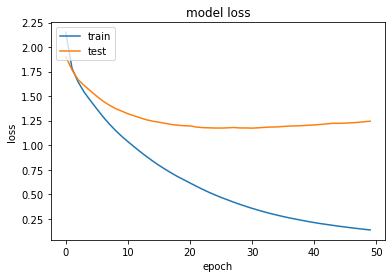

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history1
print(history.history.keys())
# summarize history1 for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history1 for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#from below plot we can see that from no of epochs greater than 20 there is no much change in loss of test data so i took no of epochs as 20

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_token_index['START_']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return decoded_sentence

In [ ]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), pi = next(test_gen)

In [ ]:
input_seq

array([[ 385., 8133., 5631.,    0.,    0.,    0.,    0.]], dtype=float32)

In [ ]:
actual_output

array([[ 2014.,  2195., 13798., 11364.,  7506.,  2511.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.]], dtype=float32)

In [ ]:
pi.shape

(1, 14, 15077)

In [ ]:
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual spa Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted spa Translation:', decoded_sentence[:-4])